In [1]:
import numpy as np
import time
from math import sqrt, pi, exp
import functools
import scipy
import matplotlib.pylab as pl
from varname import nameof


from utils.preconditioners import *
from utils.algorithms import *
from utils.functions import *
import re

import random
#random.seed(42) 

### Test case "banana"


(2, 150, 150)
[[2.85924669]
 [1.75657982]]


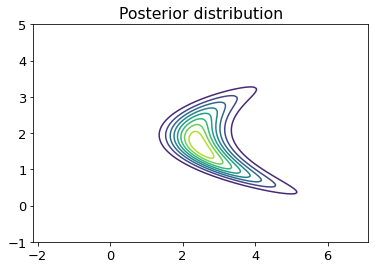

In [2]:
d = 2 

y = 0 
xmin = -2
xmax = 7
ymin= -1
ymax= 5


# potential function
sigNoise = 0.5
sigPrior = 2

G = lambda u: ((u[1]-2)**2-(u[0]-3.5) -1)
Phi = lambda u: 0.5/(sigNoise**2)*(G(u)-y)**2 #likelihood


# potential function
I = lambda u: Phi(u) + 0.5/(sigPrior**2)*np.linalg.norm(u,axis=0)**2


# Plot test case
u0s = np.linspace(xmin,xmax,150)
u1s = np.linspace(ymin,ymax,150)
U0, U1 = np.meshgrid(u0s,u1s)
U = np.stack((U0,U1))

unnorm_dens = np.exp(-I(U))
Z = np.trapz(unnorm_dens, u0s, axis=1) # sum_{i = 1}^n_grid e^{-I(u0[i],u1)}
Z = np.trapz(Z, u1s) # sum_{j = 1}^n_grid sum_{i = 1}^n_grid e^{-I(u0[i],u1[j])}
dens = unnorm_dens/Z # check the computation

plt.figure()
plt.contour(U0, U1, dens, 10)
plt.axis('equal')
plt.title("Posterior distribution")

# compute the mean
dens_times_u = U * dens
print(dens_times_u.shape)

mean_tg = np.trapz(dens_times_u, u0s, axis=1) 
mean_tg = np.trapz(mean_tg, u1s)
mean_tg = mean_tg.reshape(2, 1)
print(mean_tg)

### Try algorithms 

In [4]:
# parameters of all the algorithms


J = 20  # number of particles 
N_sim = 3000 # number of iterations
d = 2 # dimension
tau = 1e-3 # step size

N_exp = 50
consts = [1.5, 2, 3]


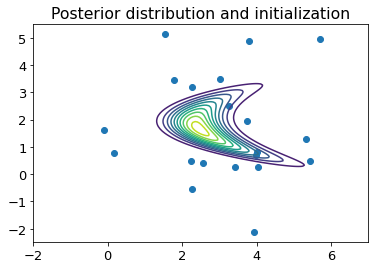

ULA: 28.830509901046753 seconds
ALDI with gradient: 28.877169847488403 seconds
iter
0
lambda min
2.3430354130927395


/Users/annakorba/Desktop/nreks/utils/algorithms.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


iter
300
lambda min
0.4734186406614486
iter
600
lambda min
0.20539101552574007
iter
900
lambda min
0.12901568837921623
iter
1200
lambda min
0.2581428535365748
iter
1500
lambda min
0.725168713716201
iter
1800
lambda min
0.4221091625964972
iter
2100
lambda min
0.33080853301643093
iter
2400
lambda min
0.2610054738156481
iter
2700
lambda min
0.47968069204571856
ALDI NR: 28.99857807159424 seconds


In [65]:


# parameters of our algorithm
const = 3

# initial position of the particles
u0 = np.random.normal(2,2,(d,J)) 

plt.figure()
plt.contour(U0, U1, np.exp(-I(U)), 10)
plt.scatter(u0[0],u0[1])
plt.title("Posterior distribution and initialization")
plt.show()

# run algorithms


# ULA
start_time = time.time()
us_list_ULA = run_ULA(I, N_sim, u0, tau)
np.save('save_data/banana/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
        +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'.npy', us_list_ULA)
print(f"ULA: {time.time()-start_time} seconds")

# ALDI 
start_time = time.time()
us_list_ALDI = run_ALDI_with_gradient(I, N_sim, u0, tau)
np.save('save_data/banana/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                    +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'.npy', us_list_ALDI)
print(f"ALDI with gradient: {time.time()-start_time} seconds")


# NRALDI (our scheme)
# eventually new parameters like stepsize

#tau_ALDINR = 1e-4
tau_ALDINR = tau

start_time = time.time()
#us_list_ALDINR, 
us_list_ALDINR = run_ALDINR(I, N_sim, u0, tau_ALDINR, const) 


# save data
np.save('save_data/banana/ALDINR_J_'\
                      +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'.npy', us_list_ALDINR)


print(f"ALDI NR: {time.time() - start_time} seconds")

# remark Anna: with tau = 10-3 and c= 1.5, the scheme diverges. However with a bigger c it is ok



## Launch a lot of experiments

In [7]:

for j in range(N_exp):
    
    print()
    print('Experiment '+str(j))
    
    # resample initialization
    # initial position of the particles
    u0 = np.random.normal(2,2,(d,J)) 
    #plt.figure()
    #plt.contour(U0, U1, np.exp(-I(U)), 10)
    #plt.scatter(u0[0],u0[1])
    #plt.axis('equal')
    #plt.title("Posterior distribution and initialization")
    #plt.show()

    # ULA
    start_time = time.time()
    us_list_ULA = run_ULA(I, N_sim, u0, tau)
    np.save('save_data/banana/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
            +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    print(f"ULA: {time.time()-start_time} seconds")

    # ALDI 
    start_time = time.time()
    us_list_ALDI = run_ALDI_with_gradient(I, N_sim, u0, tau)
    np.save('save_data/banana/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                        +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ALDI)
    print(f"ALDI with gradient: {time.time()-start_time} seconds")

    # NRALDI (our scheme)
    # eventually new parameters like stepsize
    for const in consts:
        print('constant '+str(const))
        tau_ALDINR = 1e-3
        start_time = time.time()
        us_list_ALDINR = run_ALDINR(I, N_sim, u0, tau_ALDINR, const) 
        np.save('save_data/banana/ALDINR_c_'+str(const)+'_J_'\
                              +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'_Exp_'+str(j)+'.npy', us_list_ALDINR)
        print(f"ALDI NR: {time.time()-start_time} seconds")



Experiment 0
ULA: 28.411317110061646 seconds
ALDI with gradient: 28.482173919677734 seconds
constant 1.5
iter
0
lambda min
3.732358424840607
iter
300
lambda min
0.8397557069627206
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALD

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
900
lambda min
34877650.3120417
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR dive

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
2400
lambda min
551964739.8306427
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR di

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
600
lambda min
3909891.732999711
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR div

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
2100
lambda min
3914974.0427587437
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR d

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

iter
1200
lambda min
0.19129834374081434
iter
1500
lambda min
0.409461431503625
iter
1800
lambda min
0.4060302221769213
iter
2100
lambda min
0.23866794836383062
iter
2400
lambda min
0.3240731827056985
iter
2700
lambda min
0.3528584766830326
ALDI NR: 30.3103609085083 seconds

Experiment 3
ULA: 27.556563138961792 seconds
ALDI with gradient: 29.307073831558228 seconds
constant 1.5
iter
0
lambda min
3.8479920167359585
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDI

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
600
lambda min
9998841.468422279
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR div

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

iter
300
lambda min
0.25434736014732073
iter
600
lambda min
0.48117892010382124
iter
900
lambda min
0.5079539398107952
iter
1200
lambda min
0.4688150647545435
iter
1500
lambda min
0.3423210423175693
iter
1800
lambda min
0.4365448606860928
iter
2100
lambda min
0.3211964307060292
iter
2400
lambda min
0.6089885670126082
iter
2700
lambda min
0.3990546999195549
ALDI NR: 31.399383068084717 seconds
constant 3
iter
0
lambda min
3.8479920167359585
iter
300
lambda min
0.2959127248576931
iter
600
lambda min
0.08234485979439905
iter
900
lambda min
0.29958242661849643
iter
1200
lambda min
0.4427367069745712
iter
1500
lambda min
0.35030962332625304
iter
1800
lambda min
0.13499799508448793
iter
2100
lambda min
0.16625459692680916
iter
2400
lambda min
0.17086310206047395
iter
2700
lambda min
0.0925066881422063
ALDI NR: 34.84261918067932 seconds

Experiment 4
ULA: 30.359519958496094 seconds
ALDI with gradient: 30.241327047348022 seconds
constant 1.5
iter
0
lambda min
2.180439169876426
iter
300
lambda m

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDI NR: 28.09941601753235 seconds
constant 2
iter
0
lambda min
2.5533438544797433
iter
300
lambda min
0.37009071194886717
iter
600
lambda min
0.4231636147816487
iter
900
lambda min
0.138378946125345
iter
1200
lambda min
0.19387605277971062
iter
1500
lambda min
0.2262794047994516
iter
1800
lambda min
0.5935228257253446
iter
2100
lambda min
0.4729196035398892
iter
2400
lambda min
0.8695111893607934
iter
2700
lambda min
0.5049155454506047
ALDI NR: 32.030975103378296 seconds
constant 3
iter
0
lambda min
2

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
1800
lambda min
882083.9278837191
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR di

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
iter
2400
lambda min
30699066.91492103
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR di

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
1500
lambda min
25283534.453120906
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR d

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDI NR: 21.13658595085144 seconds
constant 2
iter
0
lambda min
3.33171453461571
iter
300
lambda min
0.40044426419093726
iter
600
lambda min
0.15454259479892457
iter
900
lambda min
0.5314003832883998
iter
1200
lambda min
0.46034852268639176
iter
1500
lambda min
0.39772225465817534
iter
1800
lambda min
0.23895123964694748
iter
2100
lambda min
0.18936592588505205
iter
2400
lambda min
0.3776680604022056
iter
2700
lambda min
0.2872593849436673
ALDI NR: 31.071785926818848 seconds
constant 3
iter
0
lambda min
3.33171453461571
iter
300
lambda

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
2400
lambda min
169370302.49095437
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR d

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
1500
lambda min
41516683.78520595
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR di

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
1200
lambda min
2956050.5430157348
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR d

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
900
lambda min
35027606.17356493
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR div

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
2400
lambda min
31918411.934055325
ALDINR diverging
ALDINR d

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
1800
lambda min
147504071.5885209
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR di

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
1200
lambda min
4127810.2021716535
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR d

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
2700
lambda min
4127018.7624971867
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR d

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
1800
lambda min
11089905447.453125
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR d

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
1800
lambda min
10580405.848556506
ALDINR d

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
1500
lambda min
3560413332.892018
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR di

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDI NR: 24.246845960617065 seconds
constant 2
iter
0
lambda min
1.898389422311159
iter
300
lambda min
0.6514015102526629
iter
600
lambda min
0.2471569936884742
iter
900
lambda min
0.31261277505882024
iter
1200
lambda min
0.1653550955931097
iter
1500
lambda min
0.32313879397715134
iter
1800
lambda min
0.55488190140755
iter
2100
lambda min
0.19422028206424446
iter
2400
lambda min
0.5185074767820034
iter
2700
lambda min
0.516861213990274

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDI NR: 20.570164918899536 seconds
constant 2
iter
0
lambda min
3.195988583340143
iter
300
lambda min
0.6361537179506481
iter
600
lambda min
0.34844192118322176
iter
900
lambda min
0.257843390298697
iter
1200
lambda min
0.28105661266924714
iter
1500
lambda min
0.41655645059363444
iter
1800
lambda min
0.2630010978409565
iter
2100
lambda min
0.30136337007945124
iter
2400
lambda min
0.3109524270745258
iter
2700
lambda min
0.3062637133243164
ALDI NR: 27.818813800811768 seconds
constant 3
iter
0
lambda min
3.195988583340143
iter
300
lambda min
0.22964767414485746
iter
600
lambda min
0.2287662041188886
iter
900
lambda min
0.2951211041825817
iter
1200
lambda min
0.2705021321156557
iter
1500
lambda min
0.3152309872039315
iter
1800
lambda min
0.11649388630231632
iter
2100
lambda min
0.19369072414954397
iter
2400
lambda min
0.15858827469815603


ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
2100
lambda min
3503048.1652555894
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR d

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
1800
lambda min
9948079897.562214
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR di

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
900
lambda min
1539971.3544136242
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR di

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
900
lambda min
34028517.20931591
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR div

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
2400
lambda min
34026374.24267363
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR di

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
300
lambda min
1451096255.2956543
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR di

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
iter
1800
lambda min
848587297.9582062
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR di

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

iter
300
lambda min
0.5659842003537487
iter
600
lambda min
0.48849060511621994
iter
900
lambda min
0.4218891527268356
iter
1200
lambda min
0.5768314715548648
iter
1500
lambda min
0.28988142448427423
iter
1800
lambda min
0.1882489954577394
iter
2100
lambda min
0.3842084151403876
iter
2400
lambda min
0.24771575067217638
iter
2700
lambda min
0.4148895830081873
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR dive

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
900
lambda min
46827846131.0
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
2400
lambda min
46827489048.0
ALDINR diverg

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDI NR: 29.273466110229492 seconds

Experiment 25
ULA: 29.2934091091156 seconds
ALDI with gradient: 33.77971029281616 seconds
constant 1.5
iter
0
lambda min
3.3600878294827456
iter
300
lambda min
0.6100199131540767
iter
600
lambda min
0.8489556133619494
iter
900
lambda min
0.4775814826434866
iter
1200
lambda min
0.3793440505209553
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALD

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
1800
lambda min
109500326.89113939
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR d

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
iter
2400
lambda min
512008.6601799112
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR di

ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR diverging
ALDINR divergi

KeyboardInterrupt: 

## Check the result of one experiment

Experiment 3


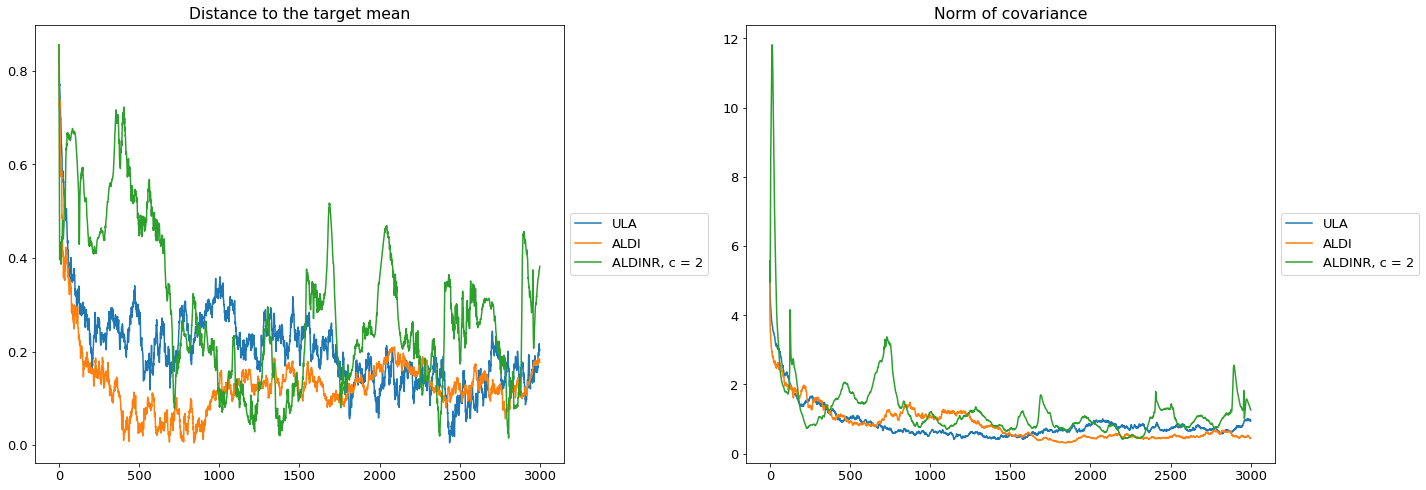

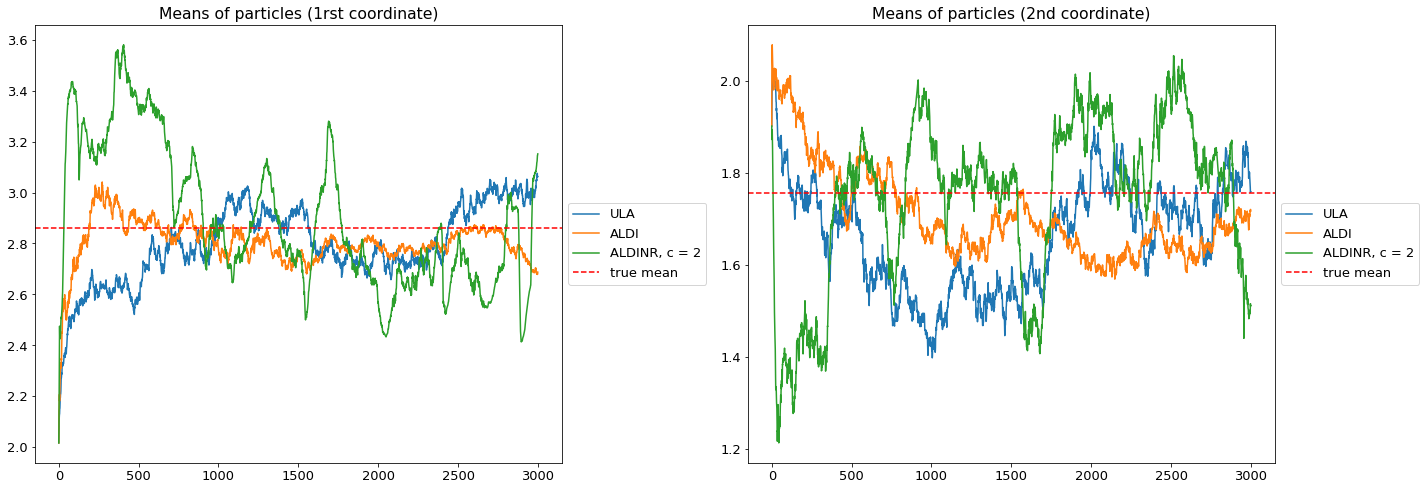

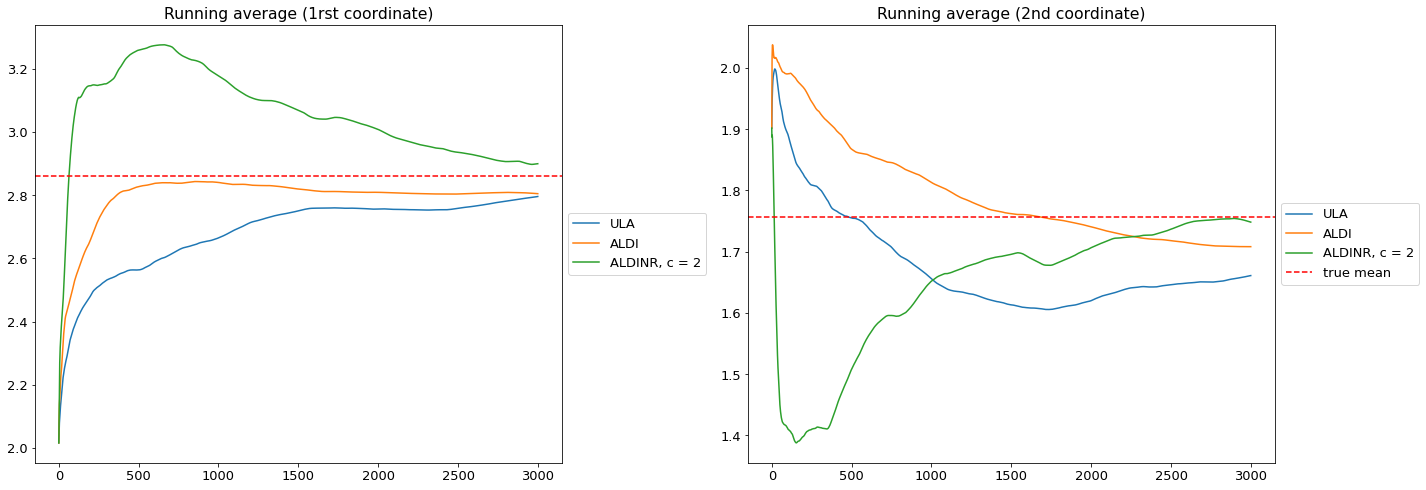

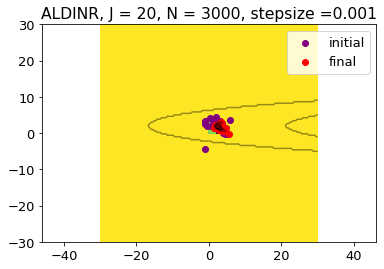

In [13]:
const = 2
# N_exp = 10
#j = np.random.randint(0, N_exp) # for c = 3 : 5,6, 9 are bad; for c = 2: 1,2 is bad 
j = 3
print('Experiment '+ str(j))

# load data

us_list_ULA = np.load('save_data/banana/ULA_J_20_Nsim_3000_tau_0.001_Exp_'+str(j)+'.npy')
us_list_ALDI = np.load('save_data/banana/ALDI_J_20_Nsim_3000_tau_0.001_Exp_'+str(j)+'.npy')
my_file = 'save_data/banana/ALDINR_c_'+ str(const) +'_J_20_Nsim_3000_tau_0.001_Exp_'+str(j)+'.npy'
us_list_ALDINR = np.load(my_file)
const = re.findall(re.escape('c_')+"(.*)"+re.escape('_J'),my_file)[0]


# compute means and covariances
d = us_list_ULA.shape[0]
J = us_list_ULA.shape[1]
N_sim = us_list_ULA.shape[2]

# means over particles: at each time compute mu_J^t = 1/J sum_{j=1}^J delta_{X_j^t}
# (vector of size (d, N_sim))
means_ULA = np.mean(us_list_ULA, axis = 1)
means_ALDI = np.mean(us_list_ALDI, axis = 1)
means_ALDINR = np.mean(us_list_ALDINR, axis = 1)


covariances_ULA = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ULA[:,:, i] = np.cov(us_list_ULA[:, :, i])*(J-1)/J
 
covariances_ALDI = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDI[:,:, i] = np.cov(us_list_ALDI[:, :, i])*(J-1)/J

covariances_ALDINR = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDINR[:,:, i] = np.cov(us_list_ALDINR[:, :, i])*(J-1)/J
    
    
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(7)
fig.set_figwidth(20)

# plot distances to target mean

plt.subplot(1, 2, 1)
distances_to_mean_ULA = np.linalg.norm(np.subtract(means_ULA, mean_tg), axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(np.subtract(means_ALDI, mean_tg), axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

distances_to_mean_ALDINR = np.linalg.norm(np.subtract(means_ALDINR, mean_tg), axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR, c = '+str(const))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distance to the target mean')

# plot distances to target covariance
plt.subplot(1, 2, 2)
distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR, c = '+str(const))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of covariance')
plt.tight_layout()
plt.show()


# plot means of particles along iterations

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(7)
fig.set_figwidth(20)

plt.subplot(1, 2, 1)
plt.plot(means_ULA[0, :], label = 'ULA' )
plt.plot(means_ALDI[0, :], label = 'ALDI' )
plt.plot(means_ALDINR[0, :], label = 'ALDINR, c = '+str(const))
plt.axhline(y = mean_tg[0], color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Means of particles (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(means_ULA[1, :], label = 'ULA' )
plt.plot(means_ALDI[1, :], label = 'ALDI' )
plt.plot(means_ALDINR[1, :], label = 'ALDINR, c = '+str(const))
plt.axhline(y = mean_tg[1], color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Means of particles (2nd coordinate)')
plt.tight_layout()
plt.show()

# plot historical average (i.e. over iterations) of means of particles

average_means_ULA = np.asarray([np.mean(means_ULA[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDI =  np.asarray([np.mean(means_ALDI[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDINR = np.asarray([np.mean(means_ALDINR[:, :i], axis = 1) for i in range(1, N_sim + 1)])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
#fig.set_figheight(7)
#fig.set_figwidth(20)

plt.subplot(1, 2, 1)
plt.plot(average_means_ULA[:, 0], label = 'ULA' )
plt.plot(average_means_ALDI[:, 0], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 0], label = 'ALDINR, c = '+str(const))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y = mean_tg[0], color='r', linestyle='--', label ='true mean')
plt.title('Running average (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(average_means_ULA[:, 1], label = 'ULA' )
plt.plot(average_means_ALDI[:, 1], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 1], label = 'ALDINR, c = '+str(const))
plt.axhline(y = mean_tg[1], color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Running average (2nd coordinate)')
plt.tight_layout()
plt.show()

tau_ALDINR = tau
name = nameof(us_list_ALDINR).lstrip('us_list')
plot_results(I, us_list_ALDINR, tau_ALDINR, name, xmin = -30, xmax = 30, ymin = -30, ymax = 30)
plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple", label = 'initial')
plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red", label = 'final')
plt.legend()
plt.savefig('diverging_experiment')

(2, 20, 0)


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(3000, 2, 20)


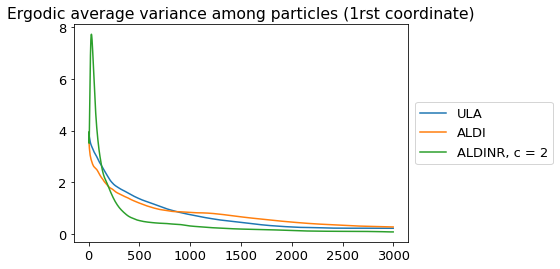

Text(0.5, 1.0, 'Ergodic average variance among particles (2rst coordinate)')

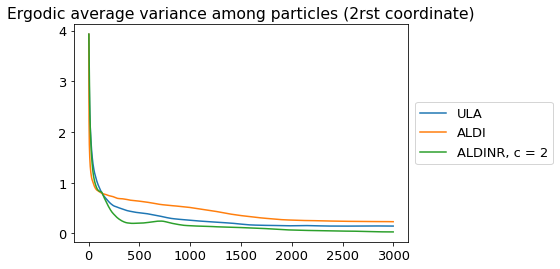

In [32]:
print(us_list_ULA[:, :, :0].shape)
# ergodic mean for each particle: for each 1 <= j <= J compute tilde{mu}_i^t = 1/T \sum_{t=1}^T delta_{X_i^t}
ergodic_means_ULA = np.asarray([np.mean(us_list_ULA[:, :, :t], axis = 2) for t in range(N_sim)])
ergodic_means_ALDI = np.asarray([np.mean(us_list_ALDI[:, :, :t], axis = 2) for t in range(N_sim)])
ergodic_means_ALDINR = np.asarray([np.mean(us_list_ALDINR[:, :, :t], axis = 2) for t in range(N_sim)])
print(ergodic_means_ULA.shape)

plt.plot(np.var(ergodic_means_ULA[:, 0], axis = 1), label = 'ULA' )
plt.plot(np.var(ergodic_means_ALDI[:, 0], axis = 1), label = 'ALDI' )
plt.plot(np.var(ergodic_means_ALDINR[:, 0], axis = 1), label = 'ALDINR, c = '+str(const))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.axhline(y = mean_tg[0], color='r', linestyle='--', label ='true mean')
plt.title('Ergodic average variance among particles (1rst coordinate)')
plt.show()


plt.plot(np.var(ergodic_means_ULA[:, 1], axis = 1), label = 'ULA' )
plt.plot(np.var(ergodic_means_ALDI[:, 1], axis = 1), label = 'ALDI' )
plt.plot(np.var(ergodic_means_ALDINR[:, 1], axis = 1), label = 'ALDINR, c = '+str(const))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.axhline(y = mean_tg[0], color='r', linestyle='--', label ='true mean')
plt.title('Ergodic average variance among particles (2rst coordinate)')

In [33]:
ergodic_means_ULAbis = np.mean(np.asarray([np.mean(us_list_ULA[:, :, :t], axis = 2) for t in range(N_sim)]), axis = 2)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [35]:
ergodic_means_ULAbis.shape

(3000, 2)

In [6]:
# test if experiment is diverging or not

const = 3
N_exp = 27
list_exp = []
for j in range(N_exp):
    my_file = 'save_data/banana/ALDINR_c_'+ str(const) +'_J_20_Nsim_3000_tau_0.001_Exp_'+str(j)+'.npy'
    us_list_ALDINR = np.load(my_file)
    
    means_ALDINR = np.mean(us_list_ALDINR, axis = 1)
    distances_to_mean_ALDINR = np.linalg.norm(np.subtract(means_ALDINR, mean_tg), axis=0)
    if distances_to_mean_ALDINR[-1]<1:
        list_exp.append(j)
print(list_exp)



[0, 1, 2, 3, 4, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 26]


### Check the result of all experiments

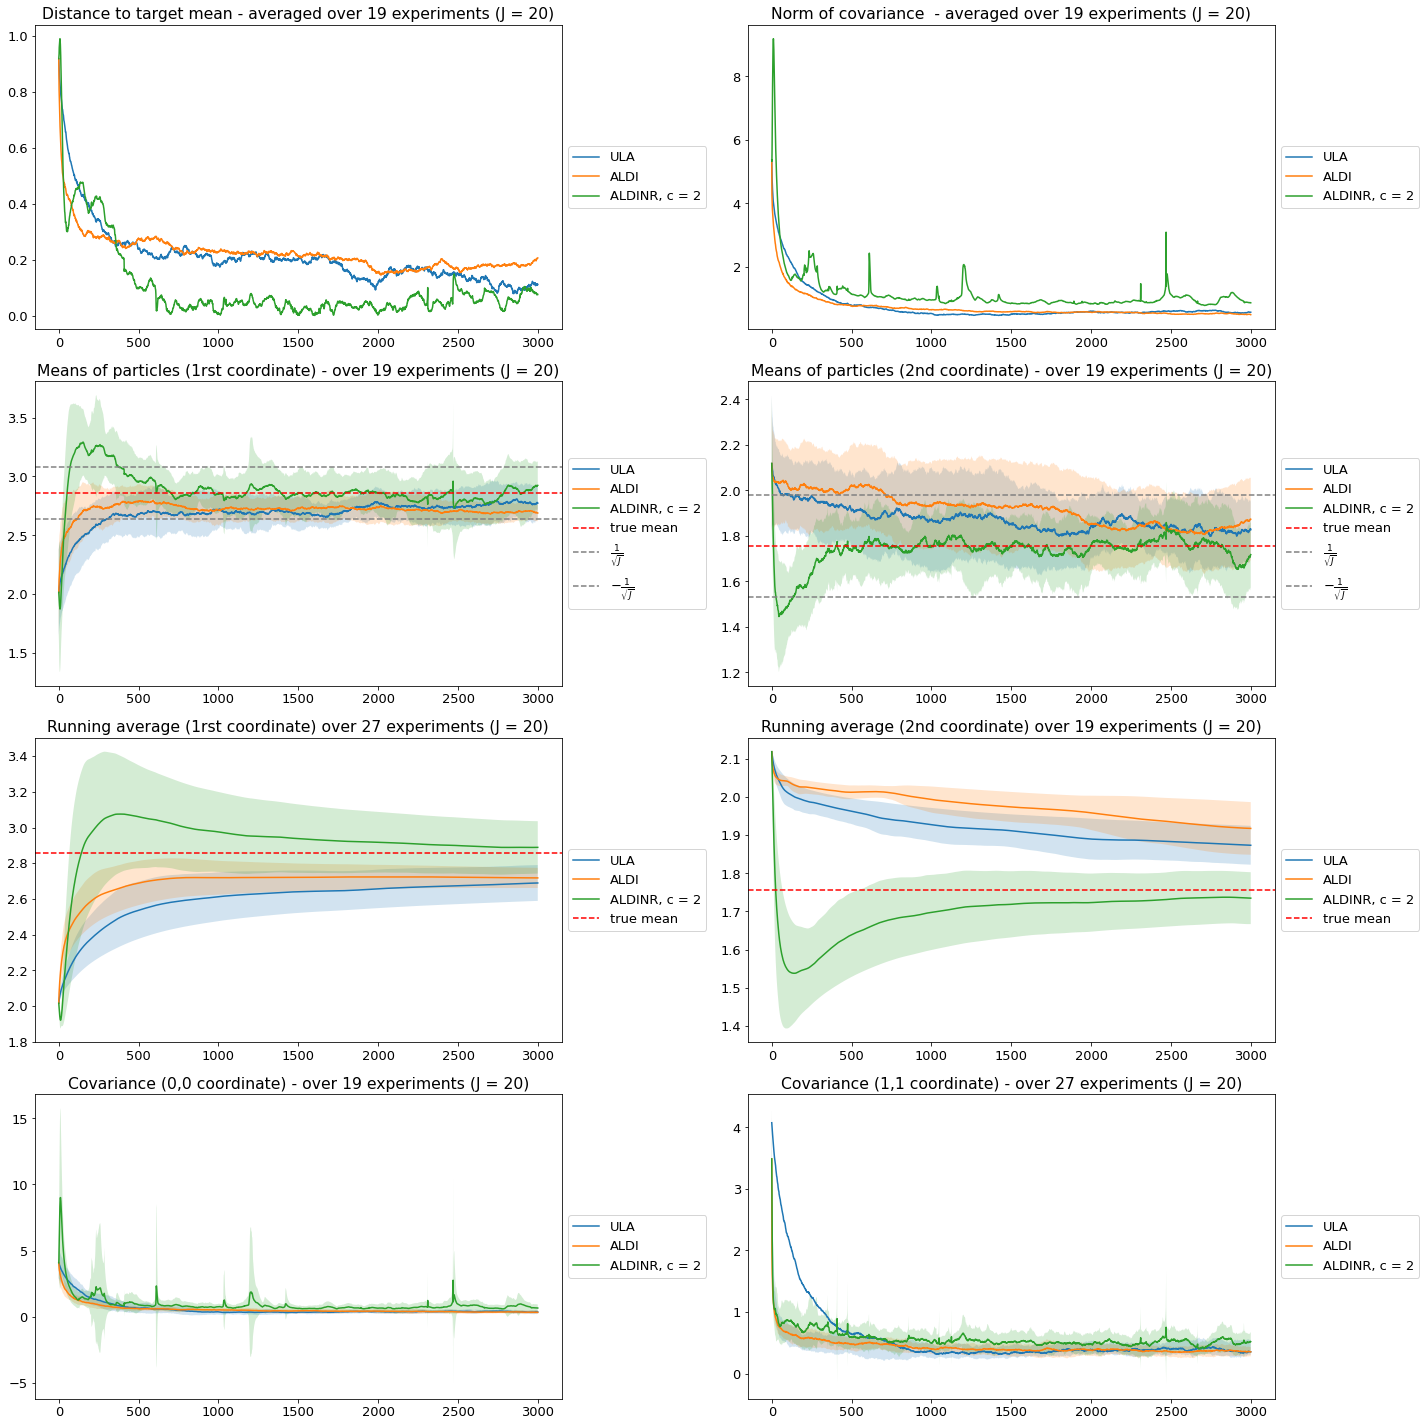

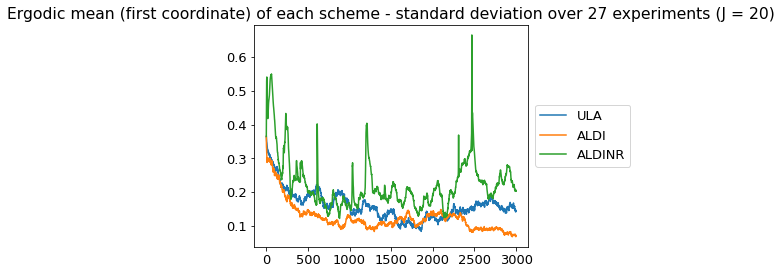

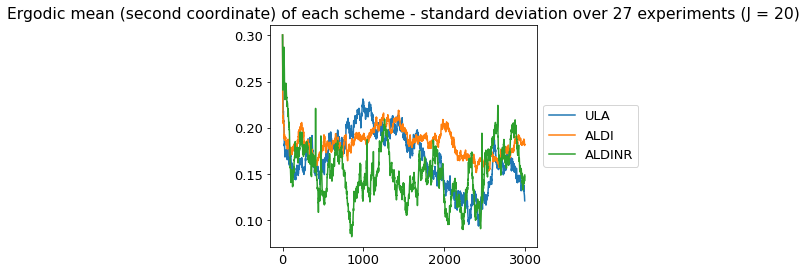

In [43]:
# choose the const
#cst  = 3
#list_exp = [0, 1, 2, 3, 4, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 26] #(for c = 3)
cst = 2
list_exp = [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 23, 24, 25] # (for c = 2)

# load some data
j = 0
us_list_ULA = np.load('save_data/banana/ULA_J_20_Nsim_3000_tau_0.001_Exp_'+str(j)+'.npy')
us_list_ALDI = np.load('save_data/banana/ALDI_J_20_Nsim_3000_tau_0.001_Exp_'+str(j)+'.npy')
my_file = 'save_data/banana/ALDINR_c_'+str(cst)+'_J_20_Nsim_3000_tau_0.001_Exp_'+str(j)+'.npy'
us_list_ALDINR = np.load(my_file)

for const in [cst]:#consts:
    
    # aggregate vector over experiments 
    means_ULA_all = np.zeros((d, N_sim, len(list_exp)))
    means_ALDI_all = np.zeros((d, N_sim, len(list_exp)))
    means_ALDINR_all = np.zeros((d, N_sim, len(list_exp)))
    
    ergodic_means_ULA_all = np.zeros((d, N_sim, len(list_exp)))
    ergodic_means_ALDI_all = np.zeros((d, N_sim, len(list_exp)))
    ergodic_means_ALDINR_all = np.zeros((d, N_sim, len(list_exp)))

    covariances_ULA_all = np.zeros((d, d, N_sim, len(list_exp)))
    covariances_ALDI_all = np.zeros((d, d, N_sim, len(list_exp)))
    covariances_ALDINR_all = np.zeros((d, d, N_sim, len(list_exp)))

    for j in list_exp:#range(N_exp):

        # load data
        us_list_ULA = np.load('save_data/banana/ULA_J_20_Nsim_3000_tau_0.001_Exp_'+str(j)+'.npy')
        us_list_ALDI = np.load('save_data/banana/ALDI_J_20_Nsim_3000_tau_0.001_Exp_'+str(j)+'.npy')
        my_file = 'save_data/banana/ALDINR_c_'+str(const)+'_J_20_Nsim_3000_tau_0.001_Exp_'+str(j)+'.npy'
        us_list_ALDINR = np.load(my_file)

        # compute means and covariances
        d = us_list_ULA.shape[0] 
        J = us_list_ULA.shape[1]
        N_sim = us_list_ULA.shape[2]

        # single vectors 
        # means of particles at each time step mu_J^t = 1/J sum_{j=1}^J delta_{X_j^t}
        # vectors of size (d, N_sim)
        means_ULA = np.mean(us_list_ULA, axis = 1)
        means_ALDI = np.mean(us_list_ALDI, axis = 1)
        means_ALDINR = np.mean(us_list_ALDINR, axis = 1)

        # collect all previous means and create the vector [mu_J^t]_{t=1}^{N_sim}
        # vectors of size (d, N_sim)
        means_ULA_all[:, :, list_exp.index(j)] = means_ULA
        means_ALDI_all[:, :, list_exp.index(j)] = means_ALDI
        means_ALDINR_all[:, :, list_exp.index(j)] = means_ALDINR
        
        # for each particle compute the ergodic mean at time 1 \le t \le N_sim
        # so we have tilde{mu}^{j,t} = 1/t sum_{t=1}^T delta_{X_j^t}
        # this is the vector [tilde{mu}^{j,t}]_{t=1}^N_sim
        # then I average over particles 
        # vectors of size (3000, 2, 20)-> (N_sim, d)        
        #ergodic_means_ULA = np.mean(np.asarray([np.mean(us_list_ULA[:, :, :t], axis = 2) for t in range(N_sim)]), axis = 2)
        #ergodic_means_ALDI = np.mean(np.asarray([np.mean(us_list_ALDI[:, :, :t], axis = 2) for t in range(N_sim)]), axis = 2)
        #ergodic_means_ALDINR = np.mean(np.asarray([np.mean(us_list_ALDINR[:, :, :t], axis = 2) for t in range(N_sim)]), axis = 2)
        
        #TODO : correct this part
        #ergodic_means_ULA_all[:, :, list_exp.index(j)] = ergodic_means_means_ULA
        #ergodic_means_ALDI_all[:, :, list_exp.index(j)] = ergodic_means_means_ALDI
        #ergodic_means_ALDINR_all[:, :, list_exp.index(j)] = ergodic_means_means_ALDINR
        
        #means_ULA_all[]

        covariances_ULA = np.ones((d, d, N_sim))
        for i in range(N_sim):
            covariances_ULA[:,:, i] = np.cov(us_list_ULA[:, :, i])*(J-1)/J

        covariances_ALDI = np.ones((d, d, N_sim))
        for i in range(N_sim):
            covariances_ALDI[:,:, i] = np.cov(us_list_ALDI[:, :, i])*(J-1)/J

        covariances_ALDINR = np.ones((d, d, N_sim))
        for i in range(N_sim):
            covariances_ALDINR[:,:, i] = np.cov(us_list_ALDINR[:, :, i])*(J-1)/J

        covariances_ULA_all[:, :, :, list_exp.index(j)] = covariances_ULA
        covariances_ALDI_all[:, :, :, list_exp.index(j)] = covariances_ALDI
        covariances_ALDINR_all[:, :, :, list_exp.index(j)] = covariances_ALDINR



    # average (over N_exp) the means
    means_ULA_over_exp = np.mean(means_ULA_all, axis = 2)
    means_ALDI_over_exp = np.mean(means_ALDI_all, axis = 2)
    means_ALDINR_over_exp = np.mean(means_ALDINR_all, axis = 2)

    # here: put std
    std_ULA_over_exp = np.std(means_ULA_all, axis = 2).T
    std_ALDI_over_exp = np.std(means_ALDI_all, axis = 2).T
    std_ALDINR_over_exp = np.std(means_ALDINR_all, axis = 2).T

    # average (over N_exp) the covariances
    covariances_ULA_over_exp = np.mean(covariances_ULA_all, axis = 3)
    covariances_ALDI_over_exp = np.mean(covariances_ALDI_all, axis = 3)
    covariances_ALDINR_over_exp = np.mean(covariances_ALDINR_all, axis = 3)



    #### PLOTS


    # plot distances to target mean
    fig, axes = plt.subplots(nrows = 4, ncols = 2)
    fig.set_figheight(20)
    fig.set_figwidth(20)

    plt.subplot(4, 2, 1)
    distances_to_mean_ULA = np.linalg.norm(np.subtract(means_ULA_over_exp, mean_tg), axis=0)
    plt.plot(distances_to_mean_ULA, label = 'ULA' )

    distances_to_mean_ALDI = np.linalg.norm(np.subtract(means_ALDI_over_exp, mean_tg), axis=0)
    plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

    distances_to_mean_ALDINR = np.linalg.norm(np.subtract(means_ALDINR_over_exp, mean_tg), axis=0)
    plt.plot(distances_to_mean_ALDINR, label = 'ALDINR, c = '+str(const)) 

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Distance to target mean - averaged over '+str(len(list_exp))+' experiments (J = '+str(J)+')')

    # plot distances to target covariance
    plt.subplot(4, 2, 2)
    distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA_over_exp[:, :, i]) for i in range(covariances_ULA.shape[2])])
    plt.plot(distances_to_covariances_ULA, label ='ULA')

    distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI_over_exp[:, :, i]) for i in range(covariances_ALDI.shape[2])])
    plt.plot(distances_to_covariances_ALDI, label ='ALDI')

    distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR_over_exp[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
    plt.plot(distances_to_covariances_ALDINR, label ='ALDINR, c = '+str(const))

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Norm of covariance  - averaged over '+str(len(list_exp))+' experiments (J = '+str(J)+')')
    #plt.tight_layout()
    #plt.show()

    # plot means of particles along iterations
    plt.subplot(4, 2, 3)
    plt.plot(range(N_sim), means_ULA_over_exp[0, :], label = 'ULA' )
    error =  np.asarray(np.std(means_ULA_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
    error_ax1 =  error[0, :] # shape (1, 3000)
    plt.fill_between(range(N_sim), means_ULA_over_exp[0, :] - error_ax1, means_ULA_over_exp[0, :] + error_ax1, alpha=0.2)

    plt.plot(range(N_sim), means_ALDI_over_exp[0, :], label = 'ALDI' )
    error =  np.asarray(np.std(means_ALDI_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
    error_ax1 =  error[0, :] # shape (1, 3000)
    plt.fill_between(range(N_sim), means_ALDI_over_exp[0, :] - error_ax1, means_ALDI_over_exp[0, :] + error_ax1, alpha=0.2)

    plt.plot(range(N_sim), means_ALDINR_over_exp[0, :], label = 'ALDINR, c = '+str(const))
    error =  np.asarray(np.std(means_ALDINR_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
    error_ax1 =  error[0, :] # shape (1, 3000)
    plt.fill_between(range(N_sim), means_ALDINR_over_exp[0, :] - error_ax1, means_ALDINR_over_exp[0, :] + error_ax1, alpha=0.2)

    plt.axhline(y = mean_tg[0], color='r', linestyle='--', label ='true mean')
    plt.axhline(y = mean_tg[0] + 1/np.sqrt(J), color='gray', linestyle='--', label = r'$\frac{1}{\sqrt{J}}$')
    plt.axhline(y = mean_tg[0] -1/np.sqrt(J), color='gray', linestyle='--', label = r'$ - \frac{1}{\sqrt{J}}$')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Means of particles (1rst coordinate) - over '+ str(len(list_exp)) +' experiments (J = '+str(J)+')')

    plt.subplot(4, 2, 4)
    plt.plot(range(N_sim), means_ULA_over_exp[1, :], label = 'ULA' )
    error =  np.asarray(np.std(means_ULA_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
    error_ax1 =  error[1, :] # shape (1, 3000)
    plt.fill_between(range(N_sim), means_ULA_over_exp[1, :] - error_ax1, means_ULA_over_exp[1, :] + error_ax1, alpha=0.2)

    plt.plot(means_ALDI_over_exp[1, :], label = 'ALDI' )
    error =  np.asarray(np.std(means_ALDI_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
    error_ax1 =  error[1, :] # shape (1, 3000)
    plt.fill_between(range(N_sim), means_ALDI_over_exp[1, :] - error_ax1, means_ALDI_over_exp[1, :] + error_ax1, alpha=0.2)

    plt.plot(means_ALDINR_over_exp[1, :], label = 'ALDINR, c = '+str(const))
    error =  np.asarray(np.std(means_ALDINR_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
    error_ax1 =  error[1, :] # shape (1, 3000)
    plt.fill_between(range(N_sim), means_ALDINR_over_exp[1, :] - error_ax1, means_ALDINR_over_exp[1, :] + error_ax1, alpha=0.2)

    plt.axhline(y = mean_tg[1], color='r', linestyle='--', label ='true mean')
    plt.axhline(y = mean_tg[1] + 1/np.sqrt(J), color='gray', linestyle='--', label = r'$\frac{1}{\sqrt{J}}$')
    plt.axhline(y = mean_tg[1] -1/np.sqrt(J), color='gray', linestyle='--', label = r'$ - \frac{1}{\sqrt{J}}$')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Means of particles (2nd coordinate) - over '+ str(len(list_exp)) +' experiments (J = '+str(J)+')')


    # plot running average
    average_means_ULA = np.asarray([np.mean(means_ULA_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)])
    average_means_ALDI =  np.asarray([np.mean(means_ALDI_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)])
    average_means_ALDINR = np.asarray([np.mean(means_ALDINR_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)])

    plt.subplot(4, 2, 5)
    plt.plot(range(N_sim), average_means_ULA[:, 0], label = 'ULA' )
    error =  np.asarray([np.std(means_ULA_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
    error_ax1 =  error[0, :] # shape (1, 3000)
    plt.fill_between(range(N_sim), average_means_ULA[:, 0] - error_ax1, average_means_ULA[:, 0] + error_ax1, alpha=0.2)

    plt.plot(range(N_sim), average_means_ALDI[:, 0], label = 'ALDI' )
    error =  np.asarray([np.std(means_ALDI_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
    error_ax1 =  error[0, :] # shape (1, 3000)
    plt.fill_between(range(N_sim), average_means_ALDI[:, 0] - error_ax1, average_means_ALDI[:, 0] + error_ax1, alpha=0.2)

    plt.plot(range(N_sim), average_means_ALDINR[:, 0], label = 'ALDINR, c = '+str(const))
    error =  np.asarray([np.std(means_ALDINR_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
    error_ax1 =  error[0, :] # shape (1, 3000)
    plt.fill_between(range(N_sim), average_means_ALDINR[:, 0] - error_ax1, average_means_ALDINR[:, 0] + error_ax1, alpha=0.2)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axhline(y= mean_tg[0], color='r', linestyle='--', label ='true mean')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Running average (1rst coordinate) over '+str(N_exp)+' experiments (J = '+str(J)+')')

    plt.subplot(4, 2, 6)
    plt.plot(range(N_sim), average_means_ULA[:, 1], label = 'ULA' )
    error =  np.asarray([np.std(means_ULA_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
    error_ax1 =  error[1, :] # shape (1, 3000)
    plt.fill_between(range(N_sim), average_means_ULA[:, 1] - error_ax1, average_means_ULA[:, 1] + error_ax1, alpha=0.2)

    plt.plot(range(N_sim), average_means_ALDI[:, 1], label = 'ALDI' )
    error =  np.asarray([np.std(means_ALDI_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
    error_ax1 =  error[1, :] # shape (1, 3000)
    plt.fill_between(range(N_sim), average_means_ALDI[:, 1] - error_ax1, average_means_ALDI[:, 1] + error_ax1, alpha=0.2)

    plt.plot(range(N_sim), average_means_ALDINR[:, 1], label = 'ALDINR, c = '+str(const))
    error =  np.asarray([np.std(means_ALDINR_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
    error_ax1 =  error[1, :] # shape (1, 3000)
    plt.fill_between(range(N_sim), average_means_ALDINR[:, 1] - error_ax1, average_means_ALDINR[:, 1] + error_ax1, alpha=0.2)

    plt.axhline(y = mean_tg[1], color='r', linestyle='--', label ='true mean')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Running average (2nd coordinate) over '+ str(len(list_exp)) +' experiments (J = '+str(J)+')')


    #  plot covariance estimate coordinate by coordinate (4 coordinates)


    plt.subplot(4, 2, 7)

    plt.plot(range(N_sim), covariances_ULA_over_exp[0, 0, :], label = 'ULA' )
    error =  np.std(covariances_ULA_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
    error_ax1 =  error[0, 0, :]
    plt.fill_between(range(N_sim), covariances_ULA_over_exp[0, 0, :] - error_ax1, covariances_ULA_over_exp[0, 0, :] + error_ax1, alpha=0.2)

    plt.plot(range(N_sim), covariances_ALDI_over_exp[0, 0, :], label = 'ALDI' )
    error =  np.std(covariances_ALDI_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
    error_ax1 =  error[0, 0, :]
    plt.fill_between(range(N_sim), covariances_ALDI_over_exp[0, 0, :] - error_ax1, covariances_ALDI_over_exp[0, 0, :] + error_ax1, alpha=0.2)

    plt.plot(range(N_sim), covariances_ALDINR_over_exp[0, 0, :], label = 'ALDINR, c = '+str(const) )
    error =  np.std(covariances_ALDINR_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
    error_ax1 =  error[0, 0, :]
    plt.fill_between(range(N_sim), covariances_ALDINR_over_exp[0, 0, :] - error_ax1, covariances_ALDINR_over_exp[0, 0, :] + error_ax1, alpha=0.2)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Covariance (0,0 coordinate) - over '+ str(len(list_exp)) +' experiments (J = '+str(J)+')')

    plt.subplot(4, 2, 8)

    plt.plot(range(N_sim), covariances_ULA_over_exp[0, 0, :], label = 'ULA' )
    error =  np.std(covariances_ULA_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
    error_ax1 =  error[1, 1, :]
    plt.fill_between(range(N_sim), covariances_ULA_over_exp[1, 1, :] - error_ax1, covariances_ULA_over_exp[1, 1, :] + error_ax1, alpha=0.2)

    plt.plot(range(N_sim), covariances_ALDI_over_exp[1, 1, :], label = 'ALDI' )
    error =  np.std(covariances_ALDI_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
    error_ax1 =  error[1, 1, :]
    plt.fill_between(range(N_sim), covariances_ALDI_over_exp[1, 1, :] - error_ax1, covariances_ALDI_over_exp[1, 1, :] + error_ax1, alpha=0.2)

    plt.plot(range(N_sim), covariances_ALDINR_over_exp[1, 1, :], label = 'ALDINR, c = '+str(const) )
    error =  np.std(covariances_ALDINR_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
    error_ax1 =  error[1, 1, :]
    plt.fill_between(range(N_sim), covariances_ALDINR_over_exp[1, 1, :] - error_ax1, covariances_ALDINR_over_exp[1, 1, :] + error_ax1, alpha=0.2)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Covariance (1,1 coordinate) - over '+str(N_exp)+' experiments (J = '+str(J)+')')
    plt.tight_layout()
    plt.savefig('Banana_example_statistics_ALDINR_c_'+str(const)+'.pdf')
    plt.show()

    plt.plot(range(N_sim), std_ULA_over_exp[:, 0], label = 'ULA')
    plt.plot(range(N_sim), std_ALDI_over_exp[:, 0], label = 'ALDI')
    plt.plot(range(N_sim), std_ALDINR_over_exp[:, 0], label = 'ALDINR')
    plt.title('Ergodic mean (first coordinate) of each scheme - standard deviation over '+str(N_exp)+' experiments (J = '+str(J)+')')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    #plt.savefig('Banana_example_statistics_ALDINR_c_'+str(const)+'.pdf')
    plt.show()

    
    plt.plot(range(N_sim), std_ULA_over_exp[:, 1], label = 'ULA')
    plt.plot(range(N_sim), std_ALDI_over_exp[:, 1], label = 'ALDI')
    plt.plot(range(N_sim), std_ALDINR_over_exp[:, 1], label = 'ALDINR')
    plt.title('Ergodic mean (second coordinate) of each scheme - standard deviation over '+str(N_exp)+' experiments (J = '+str(J)+')')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    #plt.savefig('Banana_example_statistics_ALDINR_c_'+str(const)+'.pdf')
    plt.show()

### to do : add step size in title

In [39]:
std_ULA_over_exp.T.shape

(3000, 2)

In [10]:
print(means_ULA.shape)
means_ULA2 = np.mean(us_list_ULA, axis = 2)
print(means_ULA2.shape)

(2, 3000)
(2, 20)


## plot statistics for ALDINR

In [ ]:

# compute means and covariances
J = us_list_ULA.shape[1]
N_sim = us_list_ULA.shape[2]


means_ULA = np.mean(us_list_ULA, axis = 1)
means_ALDI = np.mean(us_list_ALDI, axis = 1)
means_ALDINR = np.mean(us_list_ALDINR, axis = 1)

covariances_ULA = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ULA[:,:, i] = np.cov(us_list_ULA[:, :, i])*(J-1)/J
 
covariances_ALDI = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDI[:,:, i] = np.cov(us_list_ALDI[:, :, i])*(J-1)/J

covariances_ALDINR = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDINR[:,:, i] = np.cov(us_list_ALDINR[:, :, i])*(J-1)/J
    
# plot distances to target mean

distances_to_mean_ULA = np.linalg.norm(np.subtract(means_ULA, mean_tg), axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(np.subtract(means_ALDI, mean_tg), axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

distances_to_mean_ALDINR = np.linalg.norm(np.subtract(means_ALDINR, mean_tg), axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distance to mean (|| mean(particles) - mean(target)||)')

# plot means of particles along iterations

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(7)
fig.set_figwidth(20)

plt.subplot(1, 2, 1)
plt.plot(means_ULA[0, :], label = 'ULA' )
plt.plot(means_ALDI[0, :], label = 'ALDI' )
plt.plot(means_ALDINR[0, :], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y = mean_tg[0], color='r', linestyle='--', label ='true mean')
plt.title('Means of particles (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(means_ULA[1, :], label = 'ULA' )
plt.plot(means_ALDI[1, :], label = 'ALDI' )
plt.plot(means_ALDINR[1, :], label = 'ALDINR')
plt.axhline(y = mean_tg[1], color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Means of particles (2nd coordinate)')
plt.tight_layout()
plt.show()

# plot historical average (i.e. over iterations) of means of particles

average_means_ULA = np.asarray([np.mean(means_ULA[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDI =  np.asarray([np.mean(means_ALDI[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDINR = np.asarray([np.mean(means_ALDINR[:, :i], axis = 1) for i in range(1, N_sim + 1)])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
#fig.set_figheight(7)
#fig.set_figwidth(20)

plt.subplot(1, 2, 1)
plt.plot(average_means_ULA[:, 0], label = 'ULA' )
plt.plot(average_means_ALDI[:, 0], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 0], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y = mean_tg[0], color='r', linestyle='--', label ='true mean')
plt.title('Historical average of the means of particles (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(average_means_ULA[:, 1], label = 'ULA' )
plt.plot(average_means_ALDI[:, 1], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 1], label = 'ALDINR')
plt.axhline(y = mean_tg[1], color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Historical average of the means of particles (2nd coordinate)')
plt.tight_layout()
plt.show()

distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of C along iter')
plt.show()

In [ ]:
test = np.ones((2, N_sim))
print(test.shape)
print(means_ULA.shape)
print(mean_tg)
mean_tg = mean_tg.reshape(2, 1)
np.subtract(means_ULA, mean_tg)

In [ ]:
# compute means and covariances

J = us_list_ULA.shape[1]
N_sim = us_list_ULA.shape[2]


means_ULA = np.mean(us_list_ULA, axis = 1)
means_ALDI = np.mean(us_list_ALDI, axis = 1)
means_ALDINR = np.mean(us_list_ALDINR, axis = 1)


covariances_ULA = np.ones((d, d, us_list_ULA.shape[2]))
for i in range(us_list_ULA.shape[2]):
    covariances_ULA[:,:, i] = np.cov(us_list_ULA[:, :, i])*(J-1)/J
 
covariances_ALDI = np.ones((d, d, us_list_ALDI.shape[2]))
for i in range(us_list_ALDI.shape[2]):
    covariances_ALDI[:,:, i] = np.cov(us_list_ALDI[:, :, i])*(J-1)/J

covariances_ALDINR = np.ones((d, d, us_list_ALDINR.shape[2]))
for i in range(us_list_ALDINR.shape[2]):
    covariances_ALDINR[:,:, i] = np.cov(us_list_ALDINR[:, :, i])*(J-1)/J

In [ ]:
distances_to_mean_ULA = np.linalg.norm(means_ULA - mean_target, axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(means_ALDI - mean_target, axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDINR, J ='+str(J)+' tau = '+str(tau_ALDINR))

distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR - mean_target, axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distance to mean (|| mean(particles) - mean(target)||)')

In [ ]:
distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label = 'ALDINR, J ='+str(J)+' tau = '+str(tau_ALDINR))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of C along iter')

In [ ]:
traces_of_C_ULA = np.asarray([np.trace(covariances_ULA[:, :, i]) for  i in range(covariances_ULA.shape[2])] )
traces_of_C_ALDI = np.asarray([np.trace(covariances_ALDI[:, :, i]) for  i in range(covariances_ALDI.shape[2])] )
traces_of_C_ALDINR = np.asarray([np.trace(covariances_ALDINR[:, :, i]) for  i in range(covariances_ALDINR.shape[2])] )

plt.plot(traces_of_C_ULA, label ='ULA')
plt.plot(traces_of_C_ALDI, label ='ALDI')
plt.plot(traces_of_C_ALDINR, label = 'ALDINR, J ='+str(J)+' tau = '+str(tau_ALDINR))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Trace of C along ALDINR')
